In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import schrodinger_cylindrical_2D as sc2D
from datetime import datetime 
#from scipy.special import jv, hermite
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.fft as spfft

In [2]:
#Constats in the units such that mass is in atomic mass unit (amu), 
#time is in micro seconds, distances are in micrometers. We call these notebook units
kB = 1.38064852e-23 #Boltzman's Constant
UK = (60e-6) #Trap depth in kelvin
U = kB*UK/(1.66e-27) #In energy unists converted to notebook units
hb = 6.62607004e-34*1e6/(2*np.pi*1.66e-27) #Plank's constant
wtrap = 2 #Gaussian trap wasit in micrometers
mK = 41 # mass of atom in amu
lm = 0.790 #wavelength of light forming the gaussian trap in micrometers
#rmax = 3 #maximum distance for lattice in radial direction
#Nr = 2000 # number of lattice points in radial direction
g = 9.806/1e6;#acceleration due to gravity in notebook units

rmax = 1
zmin = -5
zmax = 5
Nr = 300
Nz = 300

In [3]:
def wz(z,w0,l):
    """
    The beam waist as a function of distance z from the focus
        Inputs
        ------
        Z: float
            z value
        w0:float
           waist at focus
        l: float
           Wavelength of light
        
        Returns
        -------
        Wz: float
            waist at position z. 
    """
    return w0*np.sqrt(1+(z*l/(np.pi*w0**2))**2)

def Vfun(R, Z, params):
        """
        This function returns the potential energies 
        for a Highly focused gaussian beam. This is a Cylindrically symmteric function. 
        
        Inputs
        ------
        R: np.array
            np.array of the r axis
        Z: np.array
            np.array of the z axis
        params: list
            list of parameters for the potential energy function
        
        Returns
        -------
        V: np.array
            np.array of the potential energy of the 3D QSHO
        """
        Nr = len(R)
        Nz = len(Z)
        M = Nr * Nz
        V = np.zeros(M)
        vindex = 0
        w0 = params[1]
        l  = params[2]
        for i in range(Nr):
                for k in range(Nz):
                    w = wz(Z[k],w0,l)
                    V[vindex] = -params[0]*((w0/w)**2)*(np.exp(-2*(R[i]**2)/(w**2)))                              
                    vindex = vindex + 1
        return V

In [4]:
start_time = datetime.now()
#Find the eigenvalues and Eigenfunctions for angular momentum, l = 0
evl, evt, rlist,zlist = sc2D.schrodinger2D(rmax, Nr, 
                  zmin, zmax, Nz, 
                  Vfun, [U,wtrap,lm], 100, hb, mK, E0 =-U, l = 0,findpsi = True)
time_elapsed = datetime.now() - start_time 
print('\r','Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed)) 

evtnewl0 = evt[:,evl<-0.04*U]
evalnewl0 = np.real(evl[evl<-0.04*U])
boundstatesnol0 = np.shape(evalnewl0)[0]
boundstatesnol0

 Time elapsed (hh:mm:ss.ms) 0:00:20.264007


100

In [5]:
start_time = datetime.now()
#Find the eigenvalues and Eigenfunctions for angular momentum, l = 1
evl, evt, rlist,zlist = sc2D.schrodinger2D(rmax, Nr, 
                  zmin, zmax, Nz, 
                  Vfun, [U,wtrap,lm], 100, hb, mK, E0 =-U, l = 1,findpsi = True)
time_elapsed = datetime.now() - start_time 
print('\r','Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed)) 
dr = rlist[1]-rlist[0]
dz = zlist[1]-zlist[0]
evtnewl1 = evt[:,evl<-0.04*U]
evalnewl1 = np.real(evl[evl<-0.04*U])
boundstatesnol1 = np.shape(evalnewl1)[0]
boundstatesnol1

 Time elapsed (hh:mm:ss.ms) 0:00:23.096471


100

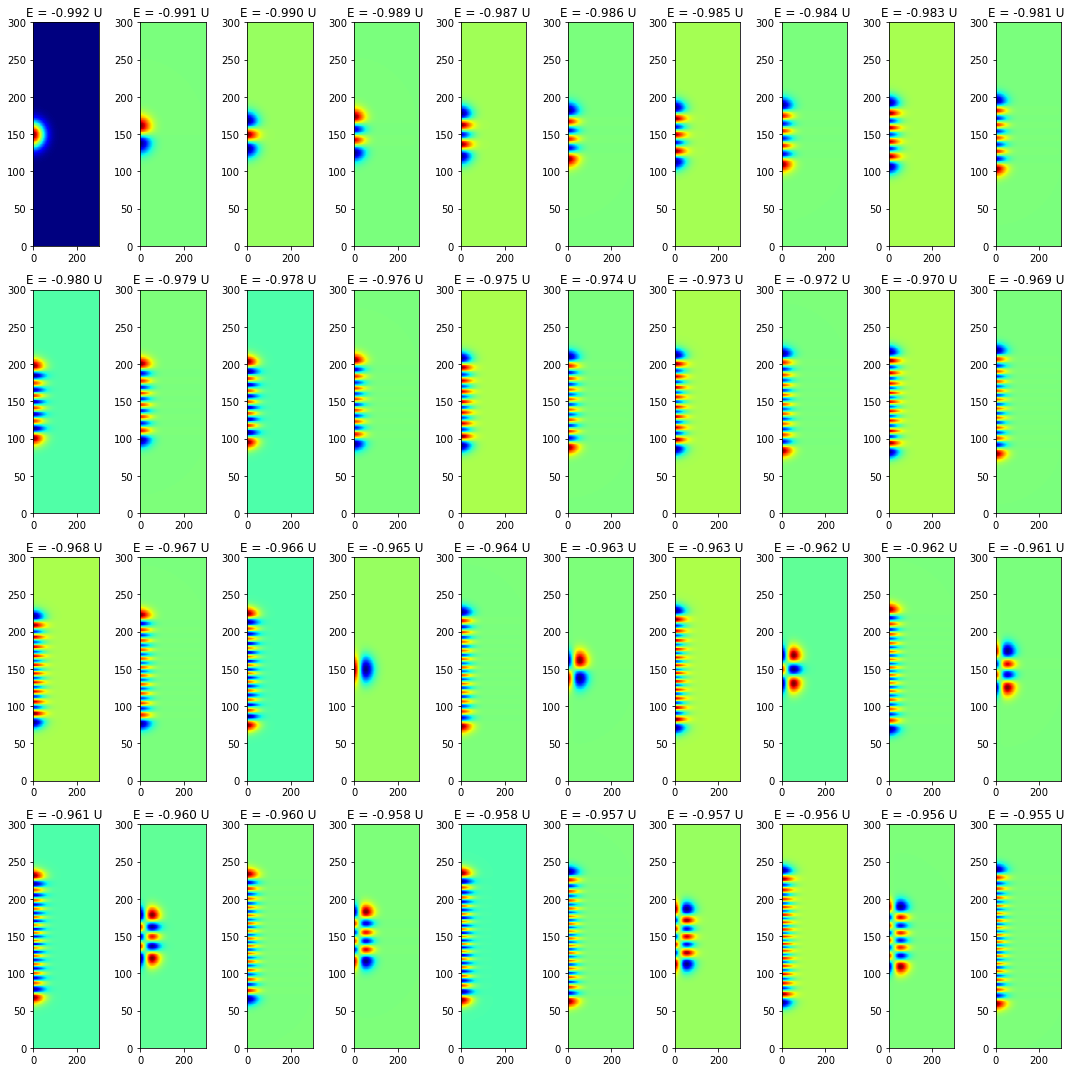

In [6]:
ntot = 40
fig = plt.figure(figsize = [15,15])
for n in range(ntot):
    psi = evtnewl0[:, n]  
    PSI = psi.reshape(Nr, Nz) 
    PSI = np.real(PSI)
    plt.subplot(4, int(ntot / 4), n + 1)    
    plt.pcolormesh(np.transpose(PSI), cmap = "jet")
    #plt.axis("equal")
    plt.title('E = %.3f U '%(evalnewl0[n]/U))
    #plt.axis("off")
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=-1)
plt.tight_layout()
plt.show()

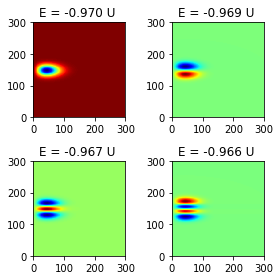

In [7]:
ntot = 4
fig = plt.figure(figsize = [4,4])
for n in range(ntot):
    psi = evtnewl1[:, n]  
    PSI = psi.reshape(Nr, Nz) 
    PSI = np.real(PSI)
    plt.subplot(2, int(ntot / 2), n + 1)    
    plt.pcolormesh(np.transpose(PSI), cmap = "jet")
    #plt.axis("equal")
    #plt.axis("off")
    plt.title('E = %.3f U '%(evalnewl1[n]/U))
plt.tight_layout()
plt.show()

In [8]:
#Reshape the eigencalues into 2D arrays
evtnewl0_respahed = []
for n in range (evtnewl0.shape[1]):
    psi = evtnewl0[:, n]  
    psi = psi.reshape(Nr, Nz) 
    evtnewl0_respahed.append(psi)
evtnewl0_respahed = np.array(evtnewl0_respahed)
evtnewl1_respahed = []
for n in range (evtnewl1.shape[1]):
    psi = evtnewl1[:, n]  
    psi = psi.reshape(Nr, Nz) 
    evtnewl1_respahed.append(psi)
evtnewl1_respahed = np.array(evtnewl1_respahed)


In [9]:
#Parameters which to convert from cylindrical to cartesian co-ordinates
samplerate = 160
xlim = 3
ylim = 3
zlim  = 10
xarray = np.arange(-xlim,xlim,2*xlim/samplerate)
yarray = np.arange(-ylim,ylim,2*ylim/samplerate)
zarray = np.arange(-zlim,zlim,2*zlim/samplerate)
xs, ys, zs = np.meshgrid(xarray, yarray,zarray, sparse=True)


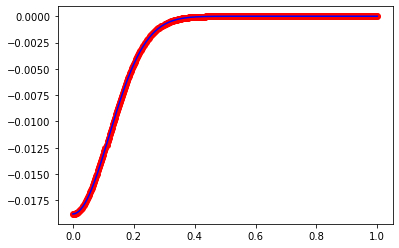

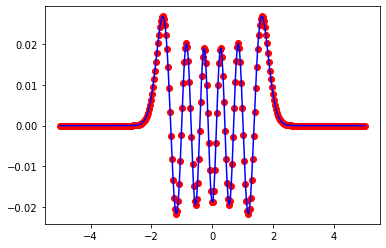

In [10]:
#Check interpolation
i = 10
fint = interpolate.RectBivariateSpline(rlist,zlist, np.real(evtnewl0_respahed[i]))
psiint = fint(rlist,zlist)
plt.plot(rlist, np.real(evtnewl0_respahed[i][:,int(Nz/2)]),'ro')
plt.plot(rlist, psiint[:,int(Nz/2)], 'b-')
plt.show()
plt.plot(zlist, np.real(evtnewl0_respahed[i][0,:]),'ro')
plt.plot(zlist, psiint[0,:], 'b-')
plt.show()



#cyltocart = np.vectorize(cyltocart, otypes=[np.complex])
#psixyz = cyltocart(coordinates,fint,0)

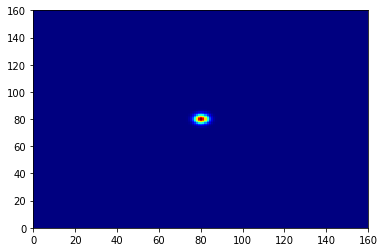

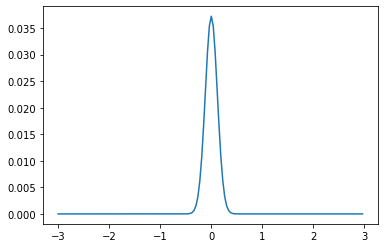

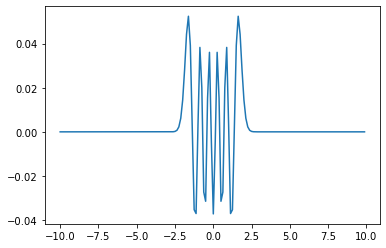

In [11]:
#coordinates[60,30,60]
#convert from cylindrical to cartesian co-ordinates
def func_eval(x,y,z,l,fn):
    r = np.sqrt(x**2+y**2)
    theta = np.arccos(x/(r+0.00001))
    fval = np.exp(1j*l*theta)*fn.ev(r,z).copy().tolist()
    return fval

def get_3D_wfn(psif,l):
    fnintp = interpolate.RectBivariateSpline(rlist,zlist, np.real(psif))
    psixyz = func_eval(xs,ys,zs,0,fnintp)
    return psixyz
psixyz = get_3D_wfn(evtnewl0_respahed[i],0)
psixyz = psixyz/np.sqrt(np.sum(np.abs(psixyz)**2))
psixyz.shape

psi = psixyz[:,:,int(samplerate/2)] 
PSI = np.abs(psi)** 2
plt.pcolormesh(np.transpose(PSI), cmap = "jet")
plt.show()
psi = psixyz[:,int(samplerate/2),int(samplerate/2)] 
plt.plot(xarray,np.abs(psi))
plt.show()
psi = psixyz[int(samplerate/2),int(samplerate/2),:] 
plt.plot(zarray,np.real(psi))
plt.show()

[160, 160, 160]


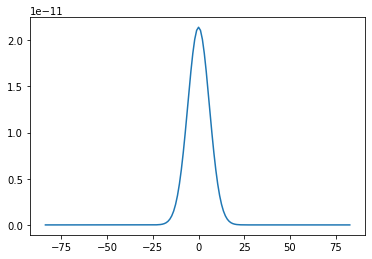

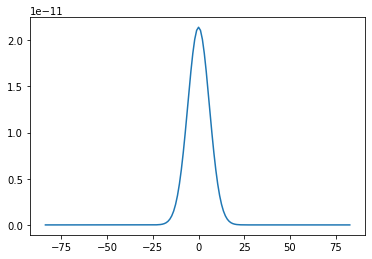

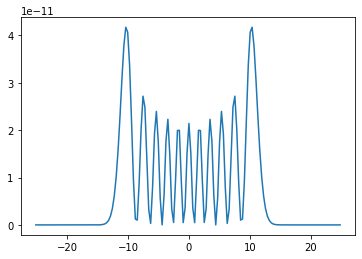

In [12]:
#Covert the wavefunction to fourier space

psifft = spfft.ifftn(psixyz,axes = [0,1,2])
psifft = spfft.fftshift(psifft)
#psifft = psifft/np.sqrt(np.sum(np.abs(psifft)**2))
freqx = spfft.fftfreq(xarray.shape[0], d=1/samplerate)*(2*np.pi)
freqx = np.sort(freqx/(2*xlim))
freqy = spfft.fftfreq(yarray.shape[0], d=1/samplerate)*(2*np.pi)
freqy = np.sort(freqy/(2*ylim))
freqz = spfft.fftfreq(zarray.shape[0], d=1/samplerate)*(2*np.pi)
freqz = np.sort(freqz/(2*zlim))

karaysq = []
for fx in spfft.ifftshift(freqx):
    arraytemp1 = []
    for fy in spfft.ifftshift(freqy):
        arraytemp2 = []
        for fz in spfft.ifftshift(freqz):
            arraytemp2.append(fx**2+fy**2+fz**2)
        arraytemp1.append(arraytemp2)
            #psixyz.append(fval)
    karaysq.append(arraytemp1)
karaysq = np.array(karaysq)
print([xarray.shape[0],yarray.shape[0],zarray.shape[0]])

plt.plot(freqx,np.abs(psifft[:,int(samplerate/2),int(samplerate/2)])**2)
plt.show()

plt.plot(freqy,np.abs(psifft[int(samplerate/2),:,int(samplerate/2)])**2)
plt.show()

plt.plot(freqz,np.abs(psifft[int(samplerate/2),int(samplerate/2),:])**2)
plt.show()

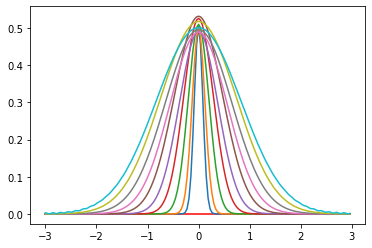

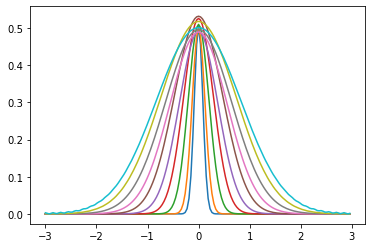

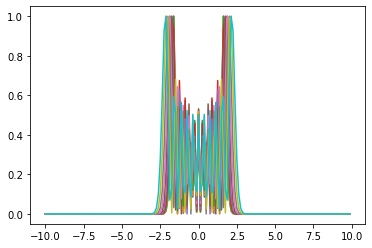

In [13]:
#Evolve the wavefunction in free space once the trap is switched off.
psifft = spfft.ifftshift(psifft)
tarray,psit = sc2D.schrodinger2D_TD_kspace(karaysq,psifft,[0,100,10],hb,mK)

psixyznn = psixyz/np.max(np.abs(psixyz))
plt.plot(xarray,np.imag(psixyznn[:,int(samplerate/2),int(samplerate/2)]),'r')
for j in range(10):
    psit_teval = psit[j]/np.max(np.abs(psit[j]))
    plt.plot(xarray,np.abs(psit_teval[:,int(samplerate/2),int(samplerate/2)])**2)
plt.show()

for j in range(10):
    psit_teval = psit[j]/np.max(np.abs(psit[j]))
    plt.plot(yarray,np.abs(psit_teval[int(samplerate/2),:,int(samplerate/2)])**2)
plt.show()

for j in range(10):
    psit_teval = psit[j]/np.max(np.abs(psit[j]))
    plt.plot(zarray,np.abs(psit_teval[int(samplerate/2),int(samplerate/2),:])**2)
plt.show()

#Compared to axial part the radial part of the wavefunction changes its size quite quickly. 
#So in release-recapture calculation, the axial part can be ignored safely. 